# What a CNN sees - Visualize the `model_scratch`

In this notebook i will show you how you can visualize the layers of a CNN. This helps us to a better understanding what a CNN sees and how it learns.  
For this demonstration I use the model from scratch constructed in dog_app.ipynb.  
The demonstration is based on the following source: [Visualizing Convolution Neural Networks using Pytorch](https://towardsdatascience.com/visualizing-convolution-neural-networks-using-pytorch-3dfa8443e74e)  
and the related Github-repo that you can find here: [Github - VisualizationCNN_Pytorch](https://github.com/Niranjankumar-c/DeepLearning-PadhAI/tree/master/DeepLearning_Materials/6_VisualizationCNN_Pytorch)

In [8]:
# import the necessary packages
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

# Load the pretrained ResNeXt101-Model from pytorch
model_transfer = models.resnext101_32x8d(pretrained=True)
# Add a Dropout layer
model_transfer.add_module('drop', nn.Dropout(0.3))
# Add a fully-connected layer - This will be the last layer
model_transfer.add_module('fc1', nn.Linear(in_features=1000, out_features=133, bias=True))

# Freeze training for all parameters
for param in model_transfer.parameters():
    param.requires_grad = False

# Replacing the last 3 layers for fine tuning
# Parameters of newly constructed modules have requires_grad=True by default
model_transfer.fc = nn.Linear(2048, 1000, bias=True)
model_transfer.drop = nn.Dropout(0.3)
model_transfer.fc1 = nn.Linear(in_features=1000, out_features=133, bias=True)

if use_cuda:
    model_transfer = model_transfer.cuda()
    
model_transfer.load_state_dict(torch.load('model_transfer_resnext101.pt'))

<All keys matched successfully>

In [5]:
# This helper-functions are imported from the related Github-repo
def plot_filters_single_channel_big(t):
    
    #setting the rows and columns
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]
    
    
    npimg = np.array(t.numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)
    
    npimg = npimg.T
    
    #fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))
    fig, ax = plt.subplots(figsize=(20, 15))  
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='gray', ax=ax, cbar=False)

    
def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    #plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()

In [4]:
# Main function to plot the weights of the model
def plot_weights(model_layer, single_channel = True, collated = False):
    '''
    Plot the weights of a pretrained/saved model
    
    Args:
        model_layer:    pretrained or saved model and layer
        single_channel: Visualization mode
        collated:       Applicable for single-channel visualization only
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    #extracting the model features at the particular layer number
    layer = model_layer
    
    #checking whether the layer is convolution layer or not 
    if isinstance(layer, nn.Conv2d):
        #getting the weight tensor data
        weight_tensor = layer.weight.data.clone()
        weight_tensor = weight_tensor.cpu()
        
        if single_channel:
            if collated:
                plot_filters_single_channel_big(weight_tensor)
            else:
                plot_filters_single_channel(weight_tensor)
        else:
            if weight_tensor.shape[1] == 3:
                plot_filters_multi_channel(weight_tensor)
            else:
                print("Can only plot weights with three channels with single channel = False")
        
    else:
        print("Can only visualize layers which are convolutional")

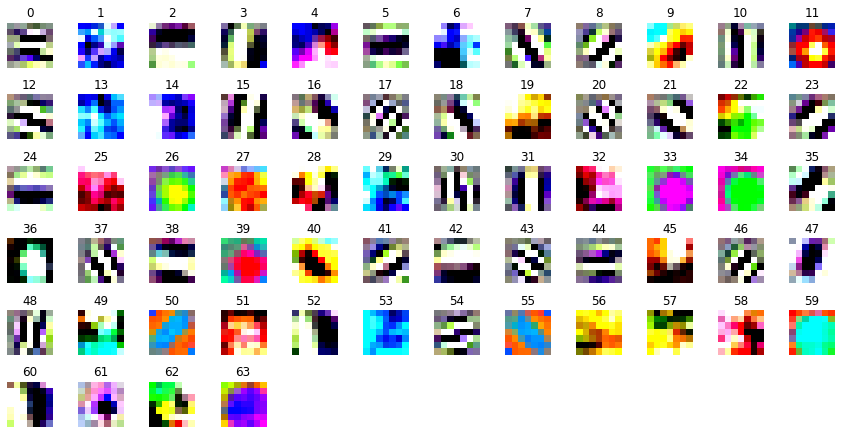

In [17]:
#visualize weights for model_scratch - first conv layer
plot_weights(model_transfer.conv1, single_channel = False, collated=True)